## Keras ile Sinir Ağlarına En Basit Giriş

> Bu not defteri, [Yeni Başlayanlar için YZ Müfredatı](http://github.com/microsoft/ai-for-beginners)'nın bir parçasıdır. Eksiksiz öğrenme materyalleri kümesi için kod deposunu ziyaret edin.

### Sinir Çerçeveleri

Sinir ağlarını eğitmek için çeşitli çerçeveler vardır. Ancak, hızlı bir başlangıç yapmak ve işlerin içeride nasıl çalıştığına dair fazla ayrıntıya girmek istemiyorsanız [Keras](https://keras.io/) kullanmayı düşünmelisiniz. Bu kısa eğitim başlamanıza yardımcı olacak ve işlerin nasıl yürüdüğünü daha iyi anlamak istiyorsanız - [Tensorflow ve Keras'a Giriş](IntroKerasTF.tr.ipynb) not defterine bakın.

### İşleri hazırlamak

Keras, Tensorflow 2.x çerçevesinin bir parçasıdır. Tensorflow'un 2.x.x sürümünün kurulu olduğundan emin olalım:
```
pip install tensorflow
```
veya
```
conda install tensorflow
```

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
print(f'Tensorflow sürümü = {tf.__version__}')
print(f'Keras sürümü" = {keras.__version__}')

Tensorflow sürümü = 2.9.0
Keras sürümü" = 2.9.0


## Temel Kavramlar: Tensör

**Tensör** çok boyutlu bir dizidir. Farklı veri türlerini temsil etmek için tensör kullanmak çok uygundur:
* 400x400 - siyah beyaz resim
* 400x400x3 - renkli resim 
* 16x400x400x3 - 16 adet renkli resimden minigrup
* 25x400x400x3 - 25 fps'lik videonun bir saniyesi
* 8x25x400x400x3 - 8 adet 1 saniyelik videodan minigrup

Tensörler, sinir ağı içindeki ağırlıkların yanı sıra, girdi/çıktı verilerini temsil etmek için de bize uygun bir yol sağlar.

## Örnek Problem

İkili sınıflandırma problemini ele alalım. Böyle bir soruna iyi bir örnek, boyutuna ve yaşına göre kötü ve iyi huylular arasında tümör sınıflandırması olabilir. Bazı örnek veriler oluşturarak başlayalım:

In [2]:
np.random.seed(0) # tekrarlanabilirlik için tohumu seçin - rastgele varyasyonların etkilerini keşfetmek için değiştirin

n = 100
X, Y = make_classification(n_samples = n, n_features=2,
                           n_redundant=0, n_informative=2, flip_y=0.05,class_sep=1.5)
X = X.astype(np.float32)
Y = Y.astype(np.int32)

split = [ 70*n//100 ]
train_x, test_x = np.split(X, split)
train_labels, test_labels = np.split(Y, split)

In [3]:
def plot_dataset(features, labels, W=None, b=None):
    # çizimi hazırlamak
    fig, ax = plt.subplots(1, 1)
    ax.set_xlabel('$x_i[0]$ -- (öznitelik 1)')
    ax.set_ylabel('$x_i[1]$ -- (öznitelik 2)')
    colors = ['r' if l else 'b' for l in labels]
    ax.scatter(features[:, 0], features[:, 1], marker='o', c=colors, s=100, alpha = 0.5)
    if W is not None:
        min_x = min(features[:,0])
        max_x = max(features[:,1])
        min_y = min(features[:,1])*(1-.1)
        max_y = max(features[:,1])*(1+.1)
        cx = np.array([min_x,max_x],dtype=np.float32)
        cy = (0.5-W[0]*cx-b)/W[1]
        ax.plot(cx,cy,'g')
        ax.set_ylim(min_y,max_y)
    fig.show()

/var/folders/_l/jnklp1bj4cl95rc01tf5vx4h0000gn/T/ipykernel_36984/3412616912.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


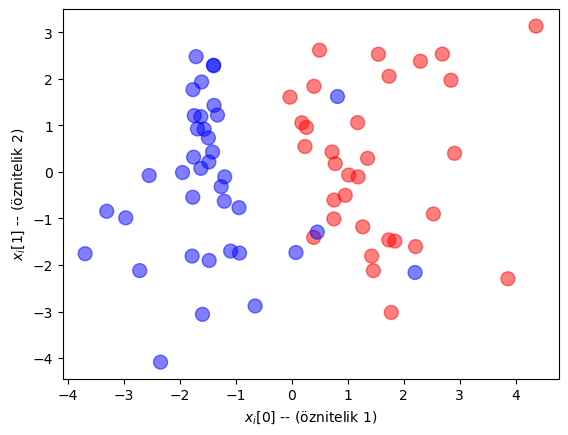

In [4]:
%matplotlib inline
plot_dataset(train_x, train_labels)

## Verileri Normalleştirme

Eğitimden önce, girdi özniteliklerimizi [0,1] (veya [-1,1]) standart aralığına getirmek yaygındır. Bunun tam nedenlerini kursun ilerleyen kısımlarında tartışacağız, ancak kısaca nedeni şudur. Ağımız üzerinden akan değerlerin çok büyük veya çok küçük olmasını önlemek istiyoruz ve normalde tüm değerleri 0'a yakın küçük bir aralıktaki tutmada hemfikiriz. Böylece ağırlıkları küçük rastgele sayılarla ilkliyoruz ve sinyalleri aynı değer aralığında tutuyoruz.

Verileri normalleştirirken en küçük değeri çıkarmamız ve aralığa bölmemiz gerekiyor. Eğitim verilerini kullanarak en küçük değeri ve değer aralığını hesaplıyoruz ve ardından eğitim kümesindeki aynı minimum/aralık değerlerini kullanarak test/geçerleme veri kümesini normalleştiriyoruz. Bunun nedeni, gerçek hayatta sadece eğitim kümesini bileceğiz ve ağın tahmin etmesi istenecek gelen tüm yeni değerleri değil. Bazen yeni değer [0,1] aralığının dışına çıkabilir, ancak bu çok önemli değildir.

In [5]:
train_x_norm = (train_x-np.min(train_x,axis=0)) / (np.max(train_x,axis=0)-np.min(train_x,axis=0))
test_x_norm = (test_x-np.min(train_x,axis=0)) / (np.max(train_x,axis=0)-np.min(train_x,axis=0))

## Tek Katmanlı Ağ Eğitimi (Algılayıcı)

Çoğu durumda, bir sinir ağı bir dizi katman olacaktır. Keras'ta `Sequential` (dizili) model kullanılarak aşağıdaki şekilde tanımlanabilir:

In [6]:
model = keras.models.Sequential()
model.add(keras.Input(shape=(2,)))
model.add(keras.layers.Dense(1))
model.add(keras.layers.Activation(keras.activations.sigmoid))

model.summary()

Metal device set to: Apple M1 Pro


2022-11-06 19:39:09.553986: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-06 19:39:09.554333: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 3         
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


Burada önce modeli oluşturuyoruz ve ardından ona katmanlar ekliyoruz:
* İlk `Input` (Girdi) katmanı (aslında katman diyemeyiz) ağın girdi boyutunun beyanını içerir.
* `Dense` (yoğun) katman, eğitilebilir ağırlıkları içeren gerçek algılayıcıdır.
* Son olarak, ağın sonucunu 0-1 aralığına getirmek (onu olasılık yapmak) için *sigmoid* `Activation` (etkinleştirme) işlevine sahip bir katman vardır.

Girdi boyutu ve etkinleştirme işlevi, kısa olması için doğrudan `Dense` katmanında da belirtilebilir:

In [7]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(1,input_shape=(2,),activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


Modeli eğitmeden önce, onu **derlememiz** gerekir, bu da esasen şunu belirtmek anlamına gelir:
* **Kayıp fonksiyonu**, kaybın nasıl hesaplandığını tanımlar. İki sınıflı sınıflandırma problemimiz olduğu için *ikili çapraz entropi kaybı* kullanacağız.
* **Optimizer (eniyileyici)** kullanmak için. En basit seçenek, *rasgele gradyan inişi* için `sgd`'yi kullanmaktır veya `adam` gibi daha karmaşık eniyileyicileri kullanabilirsiniz.
* Eğitimimizin başarısını ölçmek için kullanmak istediğimiz **metrikler**. Sınıflandırma görevi olduğundan, iyi bir metrik `Accuracy` (doğruluk) (veya kısaca `acc`) olacaktır.

Kaybı, metrikleri ve eniyileyiciyi dizgiler (string) olarak veya Keras çerçevesinden bazı nesneler sağlayarak belirtebiliriz. Örneğimizde, modelimizin öğrenme oranına ince ayar yapmak için `learning_rate` parametresini belirtmemiz gerekiyor ve bu nedenle Keras SGD eniyileyicisinin tam adını sağlıyoruz.

In [8]:
model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.2),loss='binary_crossentropy',metrics=['acc'])

Modeli derledikten sonra `fit` metodunu çağırarak asıl eğitimi yapabiliriz. En önemli parametreler şunlardır:
* `x` ve `y` sırasıyla eğitim verilerini, öznitelikleri ve etiketleri belirtir.
* Her dönemde geçerlemenin yapılmasını istiyorsak, bir dizi özellik ve etiket olacak olan `validation_data` parametresini belirtebiliriz.
* `epochs`, dönemlerin sayısını belirtti.
* Eğitimin minigruplarda gerçekleşmesini istiyorsak, `batch_size` parametresini belirtebiliriz. Ayrıca verileri `x`/`y`/`validation_data`'ya aktarmadan önce manuel olarak önceden toplu işleyebilirsiniz; bu durumda `batch_size` gerekmez.

In [9]:
model.fit(x=train_x_norm,y=train_labels,validation_data=(test_x_norm,test_labels),epochs=10,batch_size=1)

Epoch 1/10


2022-11-06 19:39:10.066835: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-06 19:39:10.202253: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - 2s 8ms/step - loss: 0.7261 - acc: 0.4714 - val_loss: 0.6578 - val_acc: 0.6667
Epoch 2/10
11/70 [===>..........................] - ETA: 0s - loss: 0.6590 - acc: 0.6364

2022-11-06 19:39:11.498184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - 0s 6ms/step - loss: 0.6363 - acc: 0.7000 - val_loss: 0.5965 - val_acc: 0.7667
Epoch 3/10
70/70 [==============================] - 0s 6ms/step - loss: 0.5643 - acc: 0.7857 - val_loss: 0.5456 - val_acc: 0.7667
Epoch 4/10
70/70 [==============================] - 0s 6ms/step - loss: 0.5084 - acc: 0.8143 - val_loss: 0.4868 - val_acc: 0.9333
Epoch 5/10
70/70 [==============================] - 0s 6ms/step - loss: 0.4752 - acc: 0.8857 - val_loss: 0.4628 - val_acc: 0.9000
Epoch 6/10
70/70 [==============================] - 0s 5ms/step - loss: 0.4419 - acc: 0.9286 - val_loss: 0.4313 - val_acc: 0.9000
Epoch 7/10
70/70 [==============================] - 0s 5ms/step - loss: 0.4128 - acc: 0.9143 - val_loss: 0.4014 - val_acc: 0.9000
Epoch 8/10
70/70 [==============================] - 0s 5ms/step - loss: 0.3960 - acc: 0.9143 - val_loss: 0.3805 - val_acc: 0.9333
Epoch 9/10
70/70 [==============================] - 0s 5ms/step - loss: 0.3779 - acc: 0.9143 - val_lo

Eğitimi nasıl etkilediklerini görmek için farklı eğitim parametreleriyle denemeler yapabilirsiniz:
* `batch_size` ayarının çok büyük olması (veya hiç belirtilmemesi) daha az kararlı eğitime neden olabilir, çünkü düşük boyutlu verilerle küçük toplu iş boyutları her bir özel durum için gradyanın daha kesin yönünü sağlar.
* Çok yüksek `learning_rate` (öğrenme oranı), aşırı öğrenme ile veya daha az kararlı sonuçlarla sonuçlanabilirken, çok düşük öğrenme oranı, sonuca ulaşmanın daha fazla dönem alacağı anlamına gelir.

> Ağı daha fazla eğitmek için `fit` (oturt) işlevini arka arkaya birkaç kez çağırabileceğinizi unutmayın. Eğitime sıfırdan başlamak istiyorsanız - hücreyi model tanımıyla yeniden çalıştırmanız gerekir.

Eğitimimizin işe yaradığından emin olmak için iki sınıfı ayıran çizgiyi çizelim. Ayırma çizgisi $W\times x + b = 0.5$ denklemiyle tanımlanır.

/var/folders/_l/jnklp1bj4cl95rc01tf5vx4h0000gn/T/ipykernel_36984/3412616912.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


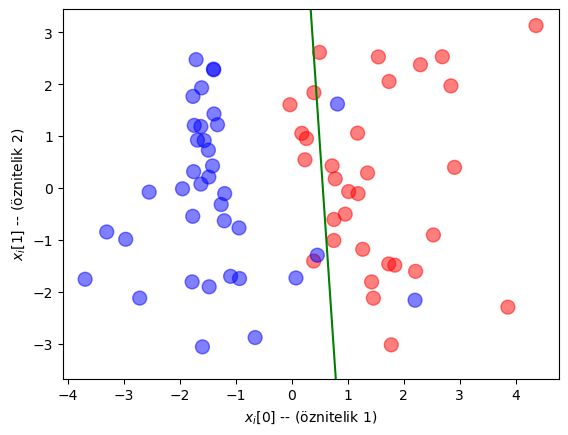

In [10]:
plot_dataset(train_x,train_labels,model.layers[0].weights[0],model.layers[0].weights[1])

## Eğitim grafiklerini çizme

`fit` işlevi, sonuç olarak, her dönemdeki kaybı ve metrikleri gözlemlemek için kullanılabilen `history` (tarih) nesnesini döndürür. Aşağıdaki örnekte küçük bir öğrenme oranı ile eğitime yeniden başlayacağız ve kayıp ve doğruluğun nasıl davrandığını gözlemleyeceğiz.

> `Sequential` modeli tanımlamak için biraz farklı sözdizimi kullandığımızı **unutmayın**. Katmanları tek tek eklemek (`add`) yerine, ilk etapta modeli oluştururken katmanların listesini de belirtebiliriz - bu biraz daha kısa sözdizimidir ve onu kullanmayı tercih edebilirsiniz.

In [11]:
model = keras.models.Sequential([
    keras.layers.Dense(1,input_shape=(2,),activation='sigmoid')])
model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.05),loss='binary_crossentropy',metrics=['acc'])
hist = model.fit(x=train_x_norm,y=train_labels,validation_data=(test_x_norm,test_labels),epochs=10,batch_size=1)

Epoch 1/10


2022-11-06 19:39:15.640677: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - 1s 7ms/step - loss: 0.7444 - acc: 0.3714 - val_loss: 0.7277 - val_acc: 0.3667
Epoch 2/10
11/70 [===>..........................] - ETA: 0s - loss: 0.6793 - acc: 0.6364

2022-11-06 19:39:16.060911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - 0s 6ms/step - loss: 0.7116 - acc: 0.4714 - val_loss: 0.7075 - val_acc: 0.4333
Epoch 3/10
70/70 [==============================] - 0s 5ms/step - loss: 0.6860 - acc: 0.5143 - val_loss: 0.6813 - val_acc: 0.5000
Epoch 4/10
70/70 [==============================] - 0s 5ms/step - loss: 0.6644 - acc: 0.5857 - val_loss: 0.6614 - val_acc: 0.6000
Epoch 5/10
70/70 [==============================] - 0s 5ms/step - loss: 0.6436 - acc: 0.7286 - val_loss: 0.6447 - val_acc: 0.7333
Epoch 6/10
70/70 [==============================] - 0s 5ms/step - loss: 0.6234 - acc: 0.7286 - val_loss: 0.6256 - val_acc: 0.8000
Epoch 7/10
70/70 [==============================] - 0s 5ms/step - loss: 0.6050 - acc: 0.8286 - val_loss: 0.6073 - val_acc: 0.8333
Epoch 8/10
70/70 [==============================] - 0s 6ms/step - loss: 0.5842 - acc: 0.7571 - val_loss: 0.5868 - val_acc: 0.9000
Epoch 9/10
70/70 [==============================] - 0s 6ms/step - loss: 0.5720 - acc: 0.9429 - val_lo

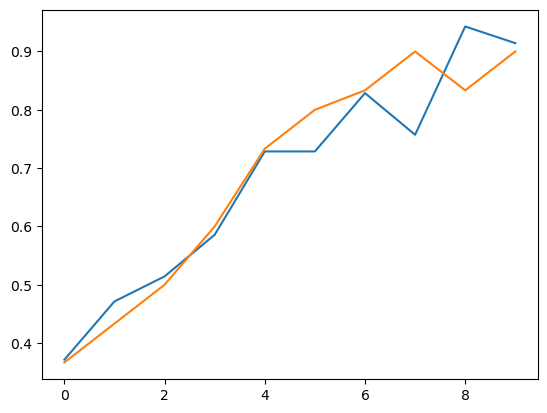

In [12]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])

## Çok Sınıflı Sınıflandırma

Bir çok sınıflı sınıflandırma problemini çözmeniz gerekiyorsa, ağınızın birden fazla çıktısı olacaktır - ki $C$ sınıflarının sayısına karşılık gelir. Her çıktı belirli bir sınıfın olasılığını içerecektir.

> Aynı şekilde ikili sınıflandırma gerçekleştirmek için iki çıktılı bir ağ da kullanabileceğinizi unutmayın. Şimdi tam olarak bunu göstereceğiz.

Bir ağdan bir $p_1,\dots, p_C$ olasılıkları kümesi çıktılamasını beklediğinizde, hepsinin toplamının 1'e eşit olmasına ihtiyacımız var. Bunu sağlamak için, son katmanda son etkinleştirme fonksiyonu olarak `softmax` kullanıyoruz. **Softmaks** bir vektör girdisi alır ve bu vektörün tüm bileşenlerinin olasılıklara dönüştürülmesini sağlar.

Ayrıca, ağın çıktısı $C$ boyutlu bir vektör olduğundan, aynı forma sahip etiketlere ihtiyacımız var. Bu, $i$ sınıfının değeri, $i$. konumda 1 ile sıfırlardan oluşan bir vektöre dönüştürüldüğünde **bire bir kodlama** kullanılarak gerçekleştirilebilir.

Sinir ağının olasılık çıktısını beklenen bire bir kodlanmış etiketle karşılaştırmak için **çapraz entropi kaybı** işlevini kullanırız. İki olasılık dağılımı alır ve ne kadar farklı olduklarının bir değerini verir.

O halde $C$ sınıfı olan çok sınıflı sınıflandırma için yapmamız gerekenleri özetlemek gerekirse:
* Ağın son katmanında $C$ adet nöronları olmalıdır.
* Son etkinleştirme işlevi **softmaks** olmalıdır.
* Kayıp, **çapraz entropi kaybı** olmalıdır.
* Etiketler **bire bir kodlamaya** dönüştürülmelidir (bu, `numpy` kullanılarak veya Keras utils `to_categorical` kullanılarak yapılabilir).

In [13]:
model = keras.models.Sequential([
    keras.layers.Dense(5,input_shape=(2,),activation='relu'),
    keras.layers.Dense(2,activation='softmax')
])
model.compile(keras.optimizers.Adam(0.01),'categorical_crossentropy',['acc'])

# Bire bir kodlamaya dönüştürmenin iki yolu
train_labels_onehot = keras.utils.to_categorical(train_labels)
test_labels_onehot = np.eye(2)[test_labels]

hist = model.fit(x=train_x_norm,y=train_labels_onehot,
                 validation_data=[test_x_norm,test_labels_onehot],batch_size=1,epochs=10)

Epoch 1/10


2022-11-06 19:39:20.200324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - 2s 11ms/step - loss: 0.8018 - acc: 0.5429 - val_loss: 0.7117 - val_acc: 0.4000
Epoch 2/10
 1/70 [..............................] - ETA: 0s - loss: 0.6854 - acc: 1.0000

2022-11-06 19:39:21.829635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - 1s 10ms/step - loss: 0.7058 - acc: 0.4286 - val_loss: 0.6920 - val_acc: 0.5333
Epoch 3/10
70/70 [==============================] - 1s 10ms/step - loss: 0.6942 - acc: 0.5429 - val_loss: 0.6883 - val_acc: 0.5000
Epoch 4/10
70/70 [==============================] - 1s 10ms/step - loss: 0.6890 - acc: 0.5286 - val_loss: 0.6836 - val_acc: 0.4667
Epoch 5/10
70/70 [==============================] - 1s 10ms/step - loss: 0.6815 - acc: 0.5286 - val_loss: 0.6752 - val_acc: 0.5667
Epoch 6/10
70/70 [==============================] - 1s 10ms/step - loss: 0.6754 - acc: 0.5429 - val_loss: 0.6652 - val_acc: 0.4667
Epoch 7/10
70/70 [==============================] - 1s 10ms/step - loss: 0.6585 - acc: 0.6714 - val_loss: 0.6493 - val_acc: 0.4667
Epoch 8/10
70/70 [==============================] - 1s 10ms/step - loss: 0.6419 - acc: 0.6286 - val_loss: 0.6240 - val_acc: 0.7667
Epoch 9/10
70/70 [==============================] - 1s 10ms/step - loss: 0.6024 - acc: 0.7571 

### Seyrek Kategorik Çapraz Entropi

Çok sınıflı sınıflandırmadaki etiketler genellikle sınıf numaralarıyla temsil edilir. Keras ayrıca, sınıf numarasının bire bir vektörler değil, tamsayılar olmasını bekleyen **seyrek kategorik çapraz entropi** adı verilen başka bir tür kayıp işlevini de destekler. Bu tür bir kayıp fonksiyonunu kullanarak eğitim kodumuzu basitleştirebiliriz:

In [14]:
model.compile(keras.optimizers.Adam(0.01),'sparse_categorical_crossentropy',['acc'])
model.fit(x=train_x_norm,y=train_labels,validation_data=[test_x_norm,test_labels],batch_size=1,epochs=10)

Epoch 1/10
 1/70 [..............................] - ETA: 18s - loss: 0.5918 - acc: 1.0000

2022-11-06 19:39:28.237102: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - 1s 8ms/step - loss: 0.5351 - acc: 0.8286 - val_loss: 0.5325 - val_acc: 0.7667
Epoch 2/10
12/70 [====>.........................] - ETA: 0s - loss: 0.3990 - acc: 0.8333

2022-11-06 19:39:28.847968: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - 0s 7ms/step - loss: 0.4780 - acc: 0.8143 - val_loss: 0.4772 - val_acc: 0.8333
Epoch 3/10
70/70 [==============================] - 0s 7ms/step - loss: 0.4411 - acc: 0.8571 - val_loss: 0.4366 - val_acc: 0.9000
Epoch 4/10
70/70 [==============================] - 0s 7ms/step - loss: 0.4054 - acc: 0.8571 - val_loss: 0.4014 - val_acc: 0.9000
Epoch 5/10
70/70 [==============================] - 0s 6ms/step - loss: 0.3745 - acc: 0.8714 - val_loss: 0.3893 - val_acc: 0.8667
Epoch 6/10
70/70 [==============================] - 0s 6ms/step - loss: 0.3534 - acc: 0.8571 - val_loss: 0.3512 - val_acc: 0.9000
Epoch 7/10
70/70 [==============================] - 0s 6ms/step - loss: 0.3263 - acc: 0.9000 - val_loss: 0.3430 - val_acc: 0.9333
Epoch 8/10
70/70 [==============================] - 0s 6ms/step - loss: 0.3072 - acc: 0.8857 - val_loss: 0.3165 - val_acc: 0.9333
Epoch 9/10
70/70 [==============================] - 0s 6ms/step - loss: 0.2857 - acc: 0.8714 - val_lo

## Çok Etiketli Sınıflandırma

> **Note** that this is very similar to using **different neural networks** to do binary classification for each particular class - only the initial part of the network (up to final classification layer) is shared for all classes.

Bazen nesnelerimizin aynı anda iki sınıfa ait olabileceği durumlar olur. Örnek olarak, resimdeki kediler ve köpekler için bir sınıflandırıcı geliştirmek istediğimizi, ancak hem kedilerin hem de köpeklerin bulunduğu durumlara da izin vermek istediğimizi varsayalım.

Çok etiketli sınıflandırma ile, bire bir kodlanmış vektör yerine, girdi örneğiyle ilgili tüm sınıflara karşılık gelen 1 konumunda bir vektöre sahip olacağız. Bu nedenle, ağın çıktısı tüm sınıflar için normalleştirilmiş olasılıklara sahip olmamalı, bunun yerine her sınıf için ayrı ayrı olmalıdır - bu, **sigmoid** etkinleştirme fonksiyonunun kullanılmasına karşılık gelir. Çapraz entropi kaybı hala bir kayıp fonksiyonu olarak kullanılabilir.

> Bunun her bir sınıf için ikili sınıflandırma yapmak için **farklı sinir ağları** kullanmaya çok benzer olduğuna **dikkat edin** - tüm sınıflar için ağın yalnızca ilk kısmı (son sınıflandırma katmanına kadar) paylaşılır.

## Sınıflandırma Kaybı Fonksiyonlarının Özeti

Ağın son katmanındaki kayıp fonksiyonu ve etkinleştirme fonksiyonuna göre ikili, çok sınıflı ve çok etiketli sınıflandırmanın farklılık gösterdiğini gördük. Yeni öğrenmeye başlıyorsanız, biraz kafa karıştırıcı olabilir, ancak burada aklınızda bulundurmanız gereken birkaç kural vardır:
* Eğer ağda bir tane çıktılı (**ikili sınıflandırma**) varsa **sigmoid** etkinleştirme işlevini kullanırız, **çok sınıflı sınıflandırma** içinse  **softmaks**.
* Çıktı sınıfı bire bir kodlama olarak temsil edilirse, kayıp işlevi **çapraz entropi kaybı** (kategorik çapraz entropi) eğer çıktı sınıf numarası içeriyorsa **seyrek kategorik çapraz entropi**  olacaktır. **İkili sınıflandırma** için **ikili çapraz entropi** kullanın (**logaritmik kayıp** ile aynıdır).
* **Çok etiketli sınıflandırma**, aynı anda birkaç sınıfa ait bir nesneye sahip olabileceğimiz zamandır. Bu durumda, etiketleri bire bir kodlama kullanarak kodlamamız ve etkinleştirme fonksiyonu olarak **sigmoid** kullanmamız gerekir, böylece her sınıf olasılığı 0 ile 1 arasında olur.

| Sınıflandırma | Etiket Formatı | Etkinleştirme Fonksiyonu | Kayıp |
|---------------|-----------------------|-----------------|----------|
| İkili         | 1. sınıf olasılığı | sigmoid | ikili çapraz entropi |
| İkili         | Bire bir kodlama (2 çıktılı) | softmax | kategorik çapraz entropi |
| Çok sınıflı   | Bire bir kodlama | softmaks | kategorik çapraz entropi |
| Çok sınıflı   | Sınıf sayısı | softmaks | seyrek kategorik çapraz entropi |
| Çok etiketli  | Bire bir kodlama | sigmoid | kategorik çapraz entropi |


**Görev**:
MNIST el yazısı rakamları için bir sınıflandırıcı eğitmede Keras'ı kullanın:
* Keras'ın MNIST dahil bazı standart veri kümeleri içerdiğine dikkat edin. MNIST'i Keras'tan kullanmak için yalnızca birkaç satır koda ihtiyacınız vardır (daha fazla bilgi [burada](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/mnist)dır).
* Farklı sayıda katman/nöron, etkinleştirme işlevleriyle birkaç ağ yapılandırması deneyin.

Ulaşabildiğiniz en iyi doğruluk nedir?

## Ana Fikirler

* **Keras**, yeni başlayanlar için gerçekten tavsiye edilir, çünkü katmanlardan ağları oldukça kolay bir şekilde oluşturmaya ve ardından sadece birkaç satır kodla eğitmeye olanak tanır.
* Standart olmayan bir mimari gerekiyorsa, Tensorflow'u biraz daha derinlemesine öğrenmeniz gerekir. Veya birinden özel mantığı bir Keras katmanı olarak uygulamasını isteyebilir ve ardından bunu Keras modellerinde kullanabilirsiniz.
* PyTorch'a da bakmak ve yaklaşımları karşılaştırmak iyi bir fikirdir.

Keras yaratıcısından Keras ve Tensorflow 2.0'nin üzerine güzel bir örnek not defterini [burada](https://t.co/k694J95PI8) bulabilirsiniz.